# Творческое задание
## Task 1

In [72]:
import pandas as pd
import missingno as msno

df = pd.read_csv('titanic.csv')

passengers = df['sex']
adult_male_count = passengers[df.adult_male == True].value_counts()['male']
grouped_by_sex = passengers.value_counts()
male_count = grouped_by_sex['male']
female_count = grouped_by_sex['female']
pclasses_with_count = df['pclass'].value_counts()

def nearest_value(items, value):
    found = items[0]
    try:
        value = float(value)
    except:
        return found
    for item in items:
        if abs(item - value) < abs(found - value):
            found = item
    return found

### Эти переменные и функции будут использоваться в последующих задачах
## Task 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


<AxesSubplot:>

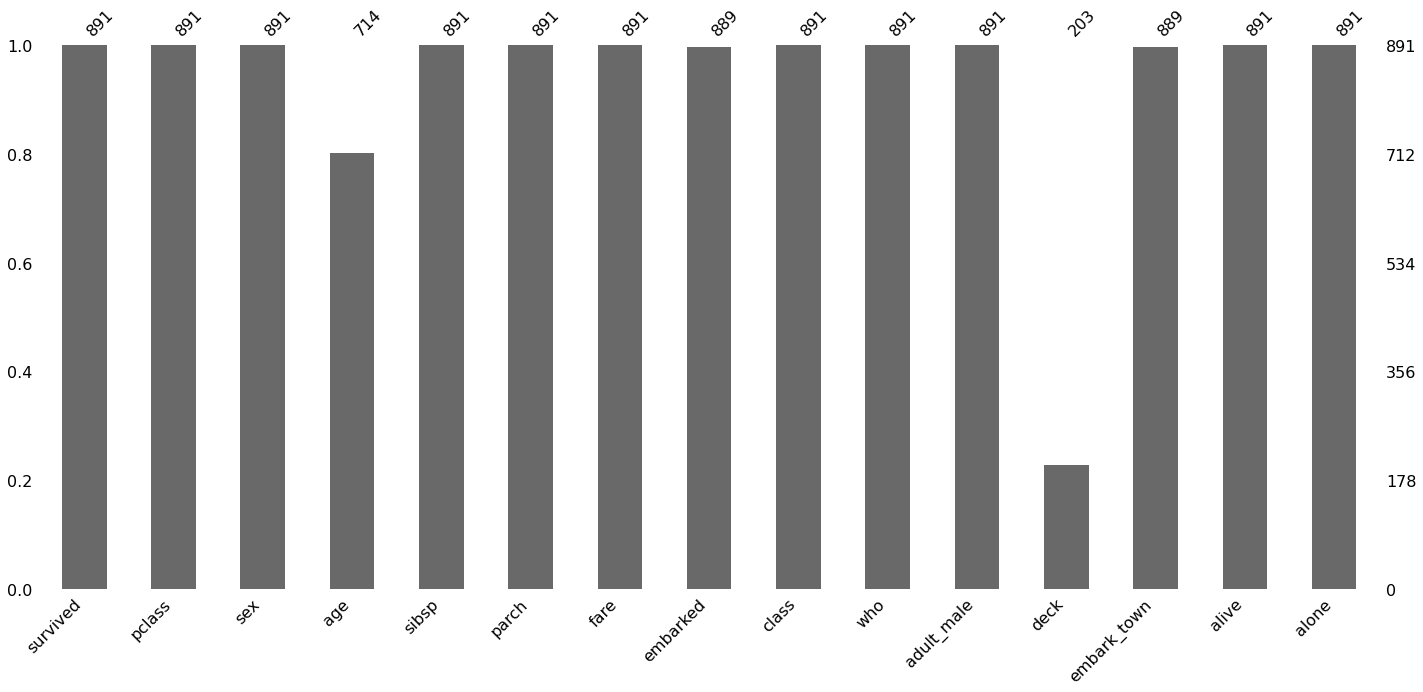

In [73]:
df.info()
msno.bar(df)

### на полученном выводе в консоли видно, что каких-то значений не хватает
- age: 714/891 
- deck: 203/891 
- embark_town: 889/891
- embarked: 889/891

## Напишем решение для каждого столбца

### Перед написанием решения для других колонок, удалим колонки, не несущие полезной информации. 

In [74]:
del df['alive']

### В колонке survived храняться числа 1 или 0
- 1 - выжил
- 0 - не выжил
### А в колонке alive храниться та же информация только словами
- yes - выжил
- no - не выжил
#### поэтому удалим именно её

In [75]:
del df['class']

### pclass
> также как и с предыдующей колонкой данные храняться словами, когда в другой колонке (class) те же самые данные храняться в цифрах

In [76]:
del df['embark_town']

### embarked == embark_town

#### также можно заметить, что если человек мужчина (male), то значение adult_male у него будет True, иначе False. Поэтому взрослый человек или нет, можно смотреть по колонке who, но удалять эту колонку я не буду, потому что по ней это смотреть удобнее

### Остальные пропуски заполним на основе данных в таблице
> колонку с возрастами заполним самыми часто встречающимися значениями из категорий who

In [77]:
man_age_mode = float(df[df.who == 'man']['age'].mode()[0])
woman_age_mode = float(df[df.who == 'woman']['age'].mode()[0])
child_age_mode = float(df[df.who == 'child']['age'].mode()[0])
df.loc[((df['age'].isna() == True) & (df['who'] == 'man')), 'age'] = man_age_mode
df.loc[((df['age'].isna() == True) & (df['who'] == 'woman')), 'age'] = woman_age_mode
df.loc[((df['age'].isna() == True) & (df['who'] == 'child')), 'age'] = child_age_mode

#### Колонку embarked заполним на основе средней цены билета каждого из пунктов отправки пассажиров и их классов

для наглядности сделаем визуализацию данных с помощью библиотеки missingno

In [78]:
print(df.groupby(['pclass', 'embarked']).describe()['fare'])
means_fares_class_embark = {
    '1': {
        df[(df.embarked == 'S') & (df.pclass == 1)]['fare'].mean(): 'S',
        df[(df.embarked == 'Q') & (df.pclass == 1)]['fare'].mean(): 'Q',
        df[(df.embarked == 'C') & (df.pclass == 1)]['fare'].mean(): 'C'
    },
    '2': {
        df[(df.embarked == 'S') & (df.pclass == 2)]['fare'].mean(): 'S',
        df[(df.embarked == 'Q') & (df.pclass == 2)]['fare'].mean(): 'Q',
        df[(df.embarked == 'C') & (df.pclass == 2)]['fare'].mean(): 'C'
    },
    '3': {
        df[(df.embarked == 'S') & (df.pclass == 3)]['fare'].mean(): 'S',
        df[(df.embarked == 'Q') & (df.pclass == 3)]['fare'].mean(): 'Q',
        df[(df.embarked == 'C') & (df.pclass == 3)]['fare'].mean(): 'C'
    }
}

for i, row in df.iterrows():
    if pd.isnull(df.loc[i].embarked):
        person_pclass = str(df['pclass'][i])
        items = list(means_fares_class_embark[person_pclass])
        fare_for_missing_value = float(df['fare'][i])
        
        new_value = means_fares_class_embark[person_pclass][nearest_value(items, fare_for_missing_value)]
        df.at[i, 'embarked'] = new_value

                 count        mean        std      min      25%      50%  \
pclass embarked                                                            
1      C          85.0  104.718529  99.093935  26.5500  49.5000  78.2667   
       Q           2.0   90.000000   0.000000  90.0000  90.0000  90.0000   
       S         127.0   70.364862  58.811278   0.0000  29.2500  52.0000   
2      C          17.0   25.358335  11.345067  12.0000  13.8625  24.0000   
       Q           3.0   12.350000   0.000000  12.3500  12.3500  12.3500   
       S         164.0   20.327439  13.630741   0.0000  13.0000  13.5000   
3      C          66.0   11.214083   4.871528   4.0125   7.2292   7.8958   
       Q          72.0   11.183393   6.721677   6.7500   7.7500   7.7500   
       S         353.0   14.644083  13.276609   0.0000   7.8542   8.0500   

                        75%       max  
pclass embarked                        
1      C         110.883300  512.3292  
       Q          90.000000   90.0000  
   

In [79]:
df_grouped_deck = df.groupby('deck').describe()
df_grouped_deck.to_csv('decks.csv')
print(df_grouped_deck)

     survived                                               pclass            \
        count      mean       std  min   25%  50%  75%  max  count      mean   
deck                                                                           
A        15.0  0.466667  0.516398  0.0  0.00  0.0  1.0  1.0   15.0  1.000000   
B        47.0  0.744681  0.440755  0.0  0.50  1.0  1.0  1.0   47.0  1.000000   
C        59.0  0.593220  0.495450  0.0  0.00  1.0  1.0  1.0   59.0  1.000000   
D        33.0  0.757576  0.435194  0.0  1.00  1.0  1.0  1.0   33.0  1.121212   
E        32.0  0.750000  0.439941  0.0  0.75  1.0  1.0  1.0   32.0  1.312500   
F        13.0  0.615385  0.506370  0.0  0.00  1.0  1.0  1.0   13.0  2.384615   
G         4.0  0.500000  0.577350  0.0  0.00  0.5  1.0  1.0    4.0  3.000000   

      ... parch       fare                                            \
      ...   75%  max count        mean         std      min      25%   
deck  ...                                              

### Больше всего пустых ячеек в колонке deck
### Полученная таблица помогла выделить несколько важных моментов, которые необходимы для заполнения

#### Палубы
<ol>
  <li>A, B, C - палубы первого класса (121)</li>
  <li>29/33 из палуб класса D - палубы первого класса</li>
  <li>27/33 из палуб класса E - палубы первого класса</li>
  <li>4/33 из палуб класса D - палубы второго класса</li>
  <li>8/13 из палуб класса F - палубы второго класса</li>
  <li>6/33 из палуб класса E - палубы третьего класса</li>
  <li>5/13 из палуб класса F - палубы третьего класса</li>
  <li>G - палубы третьего класса (4)</li>
</ol>

#### Выживаемость
<ol>
  <li>B, D, E - 75%</li>
  <li>C, F - 60%</li>
  <li>G - 50%</li>
  <li>A - 46%</li>
</ol>

#### class 1
<ol>
    <li>A - 7</li>
    <li>B - 35</li>
    <li>C - 35</li>
    <li>D - 25</li>
    <li>E - 24</li>
</ol>

#### class 2
<ol>
    <li>F - 8</li>
</ol>

#### class 3
<ol>
    <li>G - 2</li>
</ol>

### Заполним колонку deck

In [80]:
df.loc[((df['deck'].isna() == True) & (df['pclass'] == 3)), 'deck'] = 'G'
df.loc[((df['deck'].isna() == True) & (df['pclass'] == 2)), 'deck'] = 'F'
df.loc[((df['deck'].isna() == True) & (df['pclass'] == 1)), 'deck'] = 'B'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   pclass      891 non-null    int64  
 2   sex         891 non-null    object 
 3   age         891 non-null    float64
 4   sibsp       891 non-null    int64  
 5   parch       891 non-null    int64  
 6   fare        891 non-null    float64
 7   embarked    891 non-null    object 
 8   who         891 non-null    object 
 9   adult_male  891 non-null    bool   
 10  deck        891 non-null    object 
 11  alone       891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(4)
memory usage: 71.5+ KB


### Все колонки заполнены
## Task 3.a

Пассажиров мужчин больше


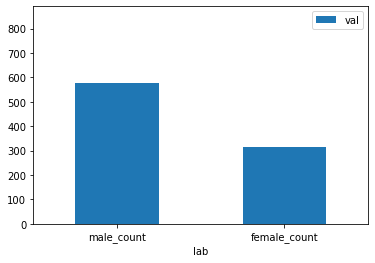

In [81]:
new_df = pd.DataFrame({'lab':['male_count', 'female_count'], 'val': [male_count, female_count]})
ax = new_df.plot.bar(x='lab', y='val', rot=0, ylim=(0, passengers.count()))

# task 3a
if male_count > female_count:
    print('Пассажиров мужчин больше')
elif male_count < female_count:
    print('Пассажиров женщин больше')
else:
    print('Пассажиров мужчин и женщин поровну')

## Task 3.b

Процент взрослых мужчин от общего числа пассажиров: 60.27


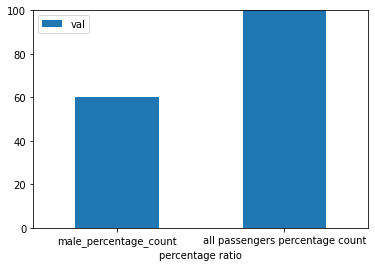

In [82]:
adult_male_percentage_ratio = 0
if female_count > 0:
    adult_male_percentage_ratio = adult_male_count * 100 / passengers.count()
elif adult_male_count > 0:
    adult_male_percentage_ratio = 100
print(f'Процент взрослых мужчин от общего числа пассажиров: {round(adult_male_percentage_ratio, 2)}')

new_df = pd.DataFrame({'percentage ratio':['male_percentage_count', 'all passengers percentage count'],
                       'val': [adult_male_percentage_ratio, 100]})

ax = new_df.plot.bar(x='percentage ratio', y='val', rot=0, ylim=(0, 100))

## Task 3.c

Количество людей в первом классе: 216
Количество людей во втором классе: 184
Количество людей в третьем классе: 491


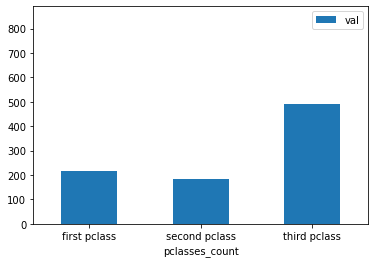

In [83]:
first_pclass_count = pclasses_with_count[1]
second_pclass_count = pclasses_with_count[2]
third_pclass_count = pclasses_with_count[3]
new_df = pd.DataFrame({'pclasses_count':['first pclass', 'second pclass', 'third pclass'], 
                       'val': [first_pclass_count, second_pclass_count, third_pclass_count]})
ax = new_df.plot.bar(x='pclasses_count', y='val', rot=0, ylim=(0, passengers.count()))
print(f'Количество людей в первом классе: {first_pclass_count}')
print(f'Количество людей во втором классе: {second_pclass_count}')
print(f'Количество людей в третьем классе: {third_pclass_count}')

## Task 4

In [84]:
df_groups_desc = df.groupby('survived').describe()
df_grouped_surv_who = df.groupby(['survived', 'who']).describe()

print(df_groups_desc['age'])
print(df_groups_desc['fare'])
df.describe()

          count       mean        std   min   25%   50%   75%   max
survived                                                           
0         549.0  28.133880  13.297097  1.00  19.0  24.0  35.0  74.0
1         342.0  27.449327  13.954576  0.42  19.0  25.0  35.0  80.0
          count       mean        std  min      25%   50%   75%       max
survived                                                                 
0         549.0  22.117887  31.388207  0.0   7.8542  10.5  26.0  263.0000
1         342.0  48.395408  66.596998  0.0  12.4750  26.0  57.0  512.3292


,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,27.871122,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.549541,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,19.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Проанализируем возраста выживших и умерших.
### Можно заметить, что показатели колонок у выживших и умерших почти совпадают. Стандартное отклонение составляет примерно 13.55 от среднего значения (mean 27.87). Чем больше это отклонение, тем менее надежное среднее значение
### 13.55 достаточно большое число, но чтобы узнать о точности решения для колонки с возрастом этого будет недостаточно

In [85]:
print(df_grouped_surv_who['age'])
df.groupby('who').describe()['age']

                count       mean        std    min    25%   50%    75%   max
survived who                                                                
0        child   34.0   7.220588   4.433330   1.00   2.25   8.0  10.00  15.0
         man    449.0  29.620267  12.898038  16.00  19.00  25.0  36.00  74.0
         woman   66.0  28.795455   9.466125  16.00  24.00  24.0  31.75  57.0
1        child   49.0   5.778980   4.880960   0.42   2.00   4.0   9.00  15.0
         man     88.0  31.329545  12.246249  16.00  20.00  29.0  36.25  80.0
         woman  205.0  30.963415  11.146303  16.00  24.00  27.0  36.00  63.0


,count,mean,std,min,25%,50%,75%,max
who,,,,,,,,
child,83.0,6.369518,4.729063,0.42,2.0,5.0,9.5,15.0
man,537.0,29.900372,12.798045,16.00,19.0,26.0,36.0,80.0
woman,271.0,30.435424,10.784784,16.00,24.0,26.0,36.0,63.0


#### такая выборка данных показывает границы возрастов: минимальный, максимальный; для разных категорий
### Большинству детей и женщин удалось спастись
#### Значения 25% 50% 75% указывают на то, какое количество людей в процентах от всех находиться в отсортированном виде с возрастом ниже данных значений

## Task 5

Процент выживших взрослых мужчин от общего числа выживших: 25.73
         survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   27.871122    0.523008    0.381594   32.204208
std      0.486592    0.836071   13.549541    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   19.000000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   24.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   35.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200
       survived      pclass         age       sibsp       parch        fare
count     342.0  342.000000  342.000000  342.000000  342.000000  342.000000
mean        1.0    1.950292   27.449327    0.473684    0.464912   48.395408
std  

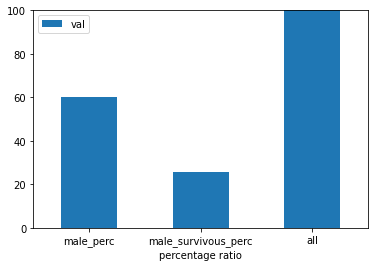

In [86]:
df[df.survived == 1].to_csv('survivors.csv')
df_only_survivors = pd.read_csv('survivors.csv')

survivors = df_only_survivors['sex']
adult_survivors_count = survivors[df_only_survivors.adult_male == True].value_counts()['male']

adult_survivors_male_percentage_ratio = 0
if female_count > 0:
    adult_survivors_male_percentage_ratio = adult_survivors_count * 100 / survivors.count()
elif adult_survivors_count > 0:
    adult_survivors_male_percentage_ratio = 100
print(f'Процент выживших взрослых мужчин от общего числа выживших: {round(adult_survivors_male_percentage_ratio, 2)}')

new_df = pd.DataFrame({'percentage ratio':['male_perc', 'male_survivous_perc', 'all'], 'val': [adult_male_percentage_ratio, adult_survivors_male_percentage_ratio, 100]})
ax = new_df.plot.bar(x='percentage ratio', y='val', rot=0, ylim=(0, 100))

columns = ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare']
print(df.describe()[columns])
print(df_only_survivors.describe()[columns])


#### Процент взрослых мужчин в таблице с выжившими уменьшился, примерно в 2,4 раза. А число мужчин уменьшилось с 537 до 88, примерно в 6,1 раза
### Рассмотрим таблицу df и df_only_survivors с помощью метода describe
- средняя цена билета увеличилась в 1,5 раза
- в колонке с возрастом изменилась 50 парцентиль, средний возраст и стандартное отклонение - немного изменились
- pclass, mean снизилось с 2.308642 до 1.950292